In [4]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


In [102]:
# All patient mutations
mutations = pd.read_csv('/cellar/users/ramarty/Data/hla/mutations/processed_mutation_files.full_tcga.all_valid_muts.csv', index_col=0)
mutations = mutations[['Hugo_Symbol', 'Barcode', 'combined']]

In [17]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)
both = pd.concat([classI.transpose(), classII.transpose()]).transpose()

Segregate patients by mutation status

In [93]:
gene = 'CTNNB1'

In [94]:
mutated_patients = [x for x in list(set(mutations[mutations.Hugo_Symbol == gene].Barcode)) if x in both.index]
not_mutated_patients = [x for x in both.index if x not in mutated_patients]
print 'Mutated patients: ', len(mutated_patients)
print 'Not mutated patients: ', len(not_mutated_patients)
patients = mutated_patients + not_mutated_patients
weight_shift = float(len(not_mutated_patients))/len(mutated_patients)
print 'Weight shift: ', weight_shift

Mutated patients:  261
Not mutated patients:  6824
Weight shift:  26.1455938697


In [95]:
# create a Series with mutation status for patients
mutation_status = pd.Series([1 for x in mutated_patients] + [0 for x in not_mutated_patients])
mutation_status.index = mutated_patients + not_mutated_patients

Reduce PHBR scores to those in gene

In [96]:
mutations_in_gene = [x for x in both.columns if gene in x]

In [97]:
both_restricted = both.ix[:, mutations_in_gene]

In [98]:
X = both_restricted.ix[patients].as_matrix()
Y = mutation_status.ix[patients]

[[0.22988505747126436, 0.7701149425287356], [0.26065719360568385, 0.7393428063943162]]
0.720393330483


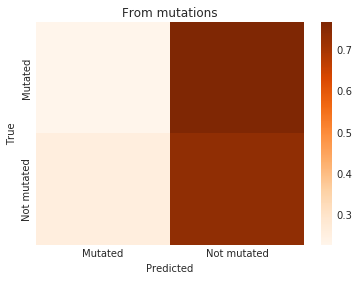

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=41)
clf = RandomForestClassifier(min_weight_fraction_leaf=.15, class_weight={1:weight_shift, 0:1})
clf = clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
mutations_clf = clf
mutations_X_test = X_test
mutations_Y_test = Y_test
matrix = []
for true_tissue in [1, 0]:
    array = []
    for predicted_tissue in [1, 0]:
        try:
        #if true_tissue == predicted_tissue:
            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in Y_test if x == true_tissue])
            #print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        #else:
         #   array.append(np.nan)
        except: 
            array.append(np.nan)
    matrix.append(array)
sns.heatmap(matrix, xticklabels=['Mutated', 'Not mutated'], yticklabels=['Mutated', 'Not mutated'], cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('From mutations')
print matrix
print len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test))

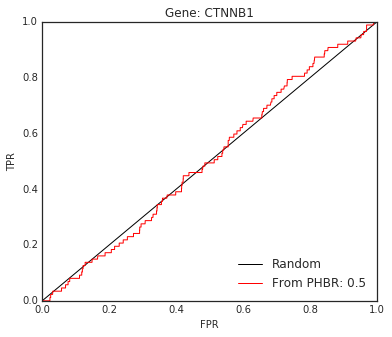

In [100]:
prediction_probabilities = clf.predict_proba(X_test)[:,1]

fpr_PHBR, tpr_PHBR, thresholds = metrics.roc_curve(Y_test, prediction_probabilities, pos_label=1)
sns.set_style("white")
plt.figure(figsize=(6,5))
plt.plot([0,1], [0, 1], c='k', label='Random')
plt.plot(fpr_PHBR, tpr_PHBR, c='r', label='From PHBR: {0}'.format(round(metrics.roc_auc_score(Y_test, 
                                                            prediction_probabilities),2)))
plt.title('Gene: {0}'.format(gene))
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [84]:
clf.feature_importances_

array([ 0.        ,  0.        ,  0.00939329,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01772392,  0.03572014,  0.        ,
        0.0578955 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.06135196,  0.        ,  0.        ,  0.04180748,  0.        ,
        0.02247238,  0.        ,  0.02390654,  0.03343884,  0.03865146,
        0.02115199,  0.        ,  0.        ,  0.        ,  0.        ,
        0.02675728,  0.        ,  0.02136123,  0.02152133,  0.01940797,
        0.03008481,  0.        ,  0.07138643,  0.02272544,  0.        ,
        0.09050877,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.05009969,
        0.        ,  0.0362751 ,  0.        ,  0.        ,  0.00666922,
        0.01513392,  0.        ,  0.01576055,  0.        ,  0.13177041,
        0.        ,  0.        ,  0.05241575,  0.        ,  0.        ,
        0.0246086 ,  0.        ,  0.        ])

In [101]:
mutations_in_gene

['CTNNB1_ifd_41224643',
 'CTNNB1_S37F',
 'CTNNB1_T41A',
 'CTNNB1_S45P',
 'CTNNB1_S37C',
 'CTNNB1_S33C',
 'CTNNB1_S33F',
 'CTNNB1_S45F',
 'CTNNB1_G34R',
 'CTNNB1_S33Y',
 'CTNNB1_D32G',
 'CTNNB1_T41I',
 'CTNNB1_G34E',
 'CTNNB1_D32N',
 'CTNNB1_S33P',
 'CTNNB1_D32Y',
 'CTNNB1_G34V',
 'CTNNB1_R587Q',
 'CTNNB1_D32V',
 'CTNNB1_K335I',
 'CTNNB1_S37A',
 'CTNNB1_H36P',
 'CTNNB1_S45Y',
 'CTNNB1_D32H',
 'CTNNB1_I35S',
 'CTNNB1_S33A',
 'CTNNB1_N387K',
 'CTNNB1_A391S',
 'CTNNB1_R515Q',
 'CTNNB1_ifd_41224643',
 'CTNNB1_S37F',
 'CTNNB1_T41A',
 'CTNNB1_S45P',
 'CTNNB1_S37C',
 'CTNNB1_S33C',
 'CTNNB1_S33F',
 'CTNNB1_S45F',
 'CTNNB1_G34R',
 'CTNNB1_S33Y',
 'CTNNB1_D32G',
 'CTNNB1_T41I',
 'CTNNB1_G34E',
 'CTNNB1_D32N',
 'CTNNB1_S33P',
 'CTNNB1_D32Y',
 'CTNNB1_G34V',
 'CTNNB1_R587Q',
 'CTNNB1_D32V',
 'CTNNB1_K335I',
 'CTNNB1_S37A',
 'CTNNB1_H36P',
 'CTNNB1_S45Y',
 'CTNNB1_D32H',
 'CTNNB1_I35S',
 'CTNNB1_S33A',
 'CTNNB1_N387K',
 'CTNNB1_A391S',
 'CTNNB1_R515Q']

In [103]:
mutations_observed = list(set(mutations[mutations.Hugo_Symbol == gene].combined))

In [104]:
len(mutations_observed)

160

In [106]:
len([x for x in mutations_observed if x not in mutations_in_gene])/float(len(mutations_observed))

0.825